













































































































































































































## Vamos a usar la librería "dtaidistance"

https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html

In [23]:
import pandas._libs.testing as _testing
import numpy as np
import pandas as pd
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import matplotlib.pyplot as plt
from datetime import datetime
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

### VARIABLES DE ENTRADA

In [24]:
## Ruta al archivo donde están los archivos con la data
path_data = "Data_Train/"
#Output_6_10_Marzo/
## Nombre del archivo donde está la data
file_data = "6f_10f_CL MAR23.Last.txt"
#"6m_10m_CL_APR23_Last.txt"

## Ruta del archivo donde están los patrones
path_patterns ="Momentum/"
## Nombre del archivo donde está el patrón
file_pattern ="Momentum_sistemas.csv"

# Ruta de los archivos de salida:
path_output ="Output/"
## Nombre del archivo de salida (tanto el csv como el HTML)
nombre_output = "entradas_largo"

### Lectura y formateo de la data

In [25]:
def fecha(data, dia):
    data["Date"] = data["ds"].str[0:8]
    data["Date"] = pd.to_datetime(data["Date"], format="%Y%m%d").dt.date
    data["Time"] = data["ds"].str[9:15]
    data["Time"] = pd.to_datetime(data["Time"], format="%H%M%S").dt.time
    data["ds"] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str))
    if dia != None:
        data = data[data["ds"].dt.day == dia]
    return data

    
dfi = pd.read_csv(path_data + file_data, sep=";", names=["ds", "Open", "High", "Low", "Close", "Volume"])
dfi = fecha(dfi, None)
dfi["signo_vela"] = dfi["Close"] - dfi["Open"] #si es positivo --> alcista; si negativo --> bajista
dfi["signo_vela_anterior"] = dfi["signo_vela"].shift(1).fillna(0)
dfi.loc[(dfi["signo_vela_anterior"]<=0) & (dfi["signo_vela"]>=0), "Price"] = dfi["High"]
dfi.loc[(dfi["signo_vela_anterior"]>=0) & (dfi["signo_vela"]>=0), "Price"] = dfi["High"]
dfi.loc[(dfi["signo_vela_anterior"]>=0) & (dfi["signo_vela"]<=0), "Price"] = dfi["Low"]
dfi.loc[(dfi["signo_vela_anterior"]<=0) & (dfi["signo_vela"]<=0), "Price"] = dfi["Low"]

<Axes: xlabel='ds'>

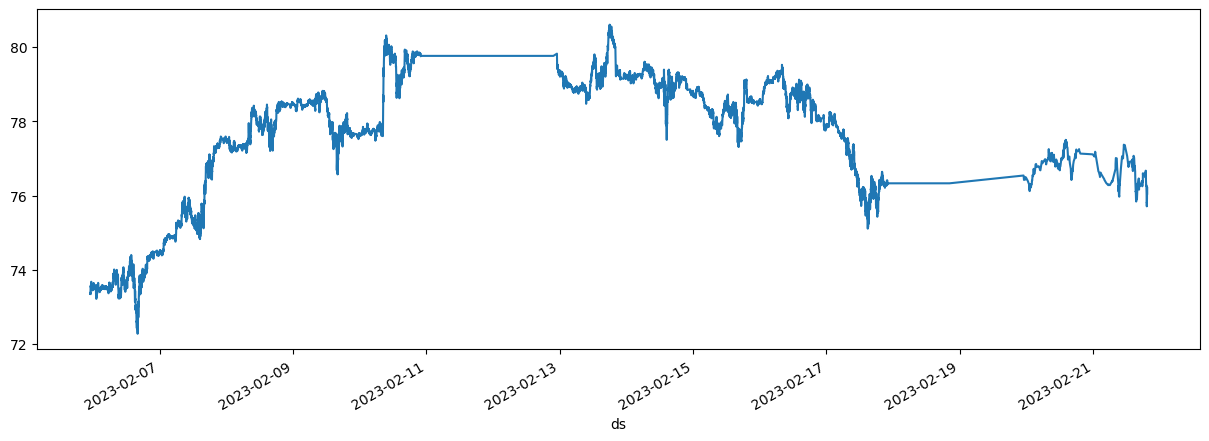

In [26]:
dfi.set_index("ds")["Close"].plot(figsize=(15,5))

In [27]:
df = dfi.copy()

In [28]:
def funcion_regresion(data, slope_min, slope_max, alarga, window):
    
    from scipy.signal import argrelextrema
    # encontrar los máximos relativos
    maximos_relativos = argrelextrema(data["Price"].values, np.greater, order = 2)
    data.loc[maximos_relativos[0], "max_relativos"] = data["Close"]
    data.loc[maximos_relativos[0], "idx_max_relativos"] = maximos_relativos[0]
    # encontrar los mínimos relativos
    minimos_relativos = argrelextrema(data["Price"].values, np.less, order = 2)
    data.loc[minimos_relativos[0], "min_relativos"] = data["Close"]
    data.loc[minimos_relativos[0], "idx_min_relativos"] = minimos_relativos[0]
    

    lista_coeffs = []
    lista_indices = []
    
    for idx, value in data[["Close", "Price","max_relativos"]].iterrows():
        if idx>window:
            datamax = data.iloc[idx-window:idx]["max_relativos"].dropna()
            if len(datamax)>1:
                x = list(datamax.index)
                y = datamax
                res = np.polyfit(x, y, 1, full=True)
                #poly = np.poly1d(np.polyfit(x, y, 1))
                coeffs = res[0]
                residuals = res[1]
                if (coeffs[0]>slope_min) & (coeffs[0]<slope_max) & (residuals<0.05): #0.01
                    coeffs = [coeffs[0],coeffs[1]]
                    if (coeffs not in lista_coeffs) & ((x[-1]+alarga)<data.index.max()):
                        lista_coeffs.append(coeffs)
                        x.append(x[-1]+alarga)
                        lista_indices.append(np.array(x))

                        

    lista_coeffs = np.array(lista_coeffs)
    lista_indices = np.array(lista_indices)
    data["recta_ini"] = np.nan
    data["recta_fin"] = np.nan
    
    for i in range(len(lista_coeffs)):
        x1 = np.arange(lista_indices[i].min(), lista_indices[i].max()+1-alarga, 1)
        poly = lista_coeffs[i][0] * x1 + lista_coeffs[i][1]
        data.loc[x1, "regresion"] = poly
        #print(list(zip(x1,poly)))
        x2 = np.arange(lista_indices[i].max()+1-alarga, lista_indices[i].max()+1, 1)
        poly = lista_coeffs[i][0] * x2 + lista_coeffs[i][1]
        data.loc[x2, "regresion_alarga"] = poly
        #print(list(zip(x2,poly)))
        #data.loc[(pd.Series(df.index).between(x1.min(), x1.max()+alarga)) & (df["recta_ini"].isnull()),"recta_ini"] = np.array(x1).min()
        #data.loc[(pd.Series(df.index).between(x1.min(), x1.max()+alarga)) & (df["recta_fin"].isnull()),"recta_fin"] = np.array(x1).max()+alarga
       
    
    return data

In [29]:
df = funcion_regresion(df, slope_min=-0.005, slope_max=0, alarga = 20, window=30)
#-0.003

In [30]:
df["regresion"] = df["regresion"] + 0.1
df["regresion_alarga"] = df["regresion_alarga"] + 0.1

In [31]:
df.index.max()

13980

In [32]:
#7 y 3
#df.loc[4500:4550][['recta_ini','recta_fin','regresion','regresion_alarga','Close']]

In [33]:
#df.loc[4800:4900, "Close"].plot(figsize=(15,6))
#(df.loc[4800:4900, "regresion"]+0.1).plot(c="green")
#(df.loc[4800:4900, "regresion_alarga"]+0.1).plot(c="red", grid=True)

In [34]:
df["trading_time"] = False
df.loc[df["ds"].dt.hour.between(8,20), "trading_time"] = True

In [35]:
df.loc[df["Volume"]>700, "idx_volume"] = df.loc[df["Volume"]>700].index

df["ma200"] = df["Close"].rolling(window=200, center=False).mean()

from pandas_ta import atr
df["atr"] = atr(df["High"], df["Low"], df["Close"], 5)

from pandas_ta import psar
df["psar"] = psar(df["High"], df["Low"], df["Close"], af=0.005)["PSARl_0.005_0.2"]

# SE DEFINE EL SHAKE-OUT O SPRING, que tenga rango y sea vela alcista o bajista (en realidad esto ultimo es secundario)
df["mecha_roja"] = False
df["mecha_verde"] = False
mask_vela_verde = (df["Close"]>df["Open"])
df.loc[mask_vela_verde & ((df["High"] - df["Low"])>(1.5*df["atr"])), "mecha_verde"] = True
mask_vela_rojo = (df["Close"]<df["Open"])
df.loc[mask_vela_rojo & ((df["High"] - df["Low"])>(1.5*df["atr"])), "mecha_roja"] = True

# SE DEFINE LA ABSORCIÓN, como que inexplicablemente la vela NO DESARROLLE.
df["close_velas_despues"] = df["Close"].shift(-2)
df["mecha_roja_absorcion"] = False
df["mecha_verde_absorcion"] = False
df.loc[(df["close_velas_despues"]<df["Close"]) & (df["mecha_verde"]==True), "mecha_verde_absorcion"] = True
df.loc[(df["close_velas_despues"]>df["Close"]) & (df["mecha_roja"]==True), "mecha_roja_absorcion"] = True
#df["mecha_verde_absorcion"] = df["mecha_verde_absorcion"].shift(2)
#df["mecha_roja_absorcion"] = df["mecha_roja_absorcion"].shift(2)


#df["volume_velas_antes"] = df["Volume"].shift(1)
df["volume_flash"] = False
df["atv"] = df["Volume"].rolling(window=10, center=False).mean()
df.loc[((2*df["atv"])<df["Volume"]), "volume_flash"] = True


df["cruce_reg"] = False
df.loc[(df["Open"]<df["regresion_alarga"]) &
       (df["Close"]>df["regresion_alarga"]) &
       (df["Close"]>df["Open"]), "cruce_reg"] = True

### Determinamos las entradas

In [36]:
df = df.reset_index(drop = True)

df.loc[:, 'zone'] = np.where(
        df['trading_time'],
        df['High'].max(),
        df['Low'].min()
    )

# Volumen Alto
df["climatico"] = np.nan
df["entrada_mecha_roja"] = np.nan
df["entrada_mecha_verde"] = np.nan
df["entrada_regresion"] = np.nan
df["entrada_volume_flash"] = np.nan
df.loc[(df["Volume"]>700), "climatico"] = df["Close"]
df.loc[(df["mecha_roja_absorcion"]==True) , "entrada_mecha_roja"] = df["Low"]
df.loc[(df["mecha_verde_absorcion"]==True), "entrada_mecha_verde"] = df["High"]
df.loc[(df["volume_flash"]==True), "entrada_volume_flash"] = df["Close"]


df["entrada_cruce_reg"] = np.nan
df.loc[(df["cruce_reg"]==True), "entrada_cruce_reg"] = df["Close"] + 0.01

In [37]:
#df.loc[4550:4700][['recta_ini','recta_fin','regresion','regresion_alarga','Close', "cruce_reg"]]

In [38]:
#df[df["cruce_reg"]==True][['Close', "Open",'regresion','regresion_alarga', "cruce_reg"]]

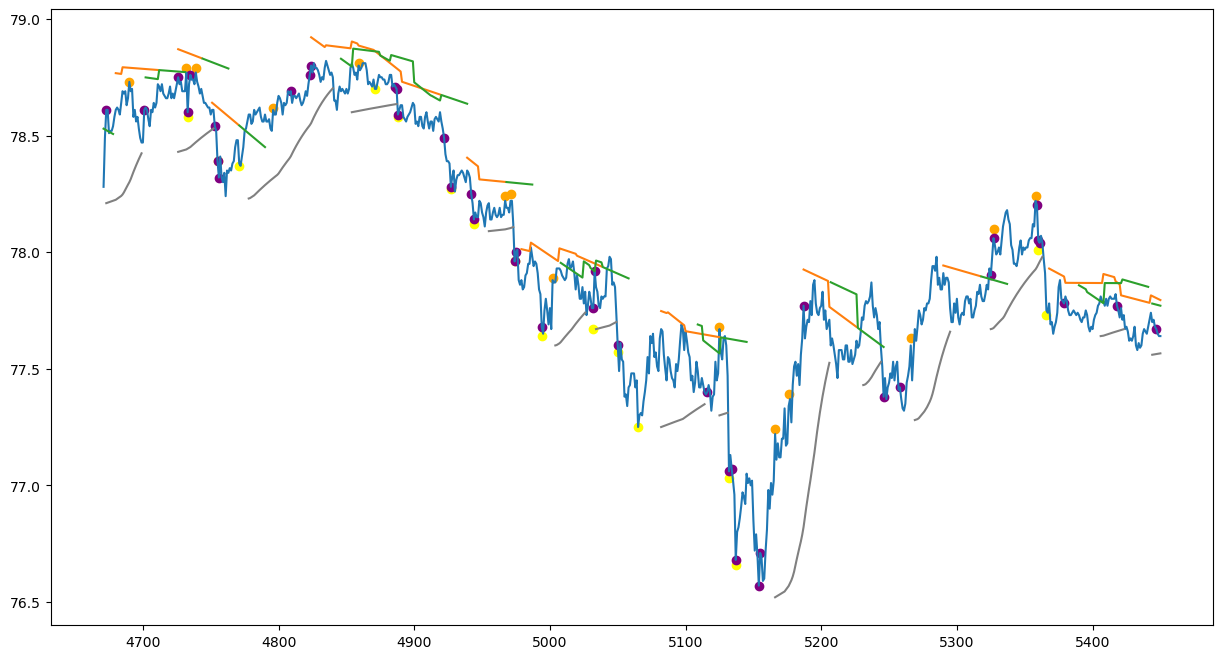

In [39]:
dft = df[df["trading_time"]==True]
dft = dft.loc[4500:5500]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(dft["Close"])
#ax.scatter(x = dft.index, y = dft["climatico"], color="green")
ax.plot(dft["regresion"])
ax.plot(dft["regresion_alarga"])
ax.plot(dft["psar"], color="grey")
#ax.plot(dft["ma200"])
ax.scatter(x = dft.index, y = dft["entrada_mecha_roja"], color="yellow")
ax.scatter(x = dft.index, y = dft["entrada_mecha_verde"], color="orange")
ax.scatter(x = dft.index, y = dft["entrada_volume_flash"], color="purple")
#ax.scatter(x = dft.index, y = dft["entrada_cruce_reg"], color="purple")

<Axes: >

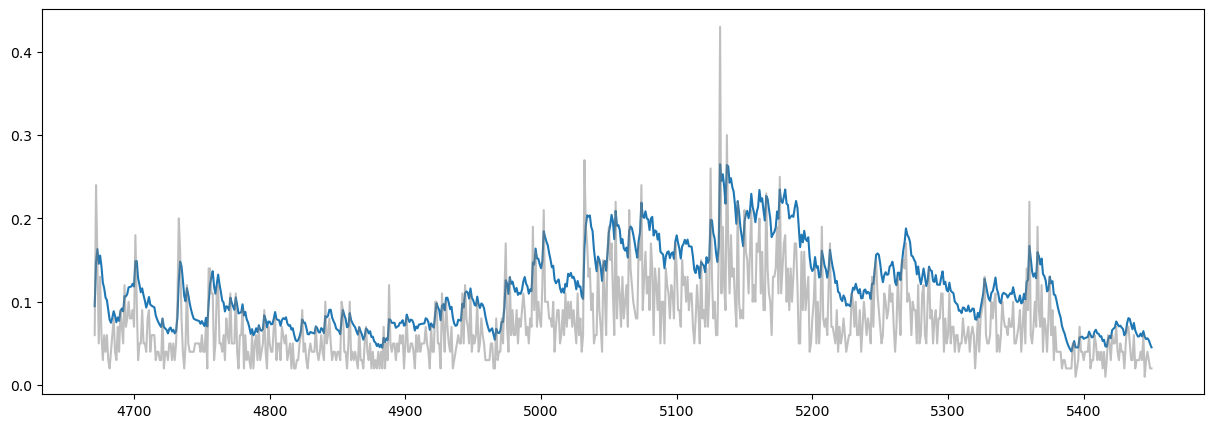

In [40]:
dft["rango"] = (dft["High"] - dft["Low"])
(1.5*dft["atr"]).plot(figsize=(15,5))
dft["rango"].plot(color="grey", alpha=0.5)

In [41]:
## Genera un archivo csv con todas las columnas calculadas hasta el mommento
## Se le puede poner el nombre que se quiera
now = datetime.now().strftime("%Y%m%d_%H%M%S")
df.to_csv(f"{path_output}{nombre_output}_{now}.csv", sep=";", index=False)

### Creamos el HTML con el gráfico de salida

In [42]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [43]:
def plot_result(df: pd.DataFrame):

    df["color"] = "blue"
    df["color2"] = "brown"
    df.loc[df["climatico"]==df["Close"],"color2"] = "orange"
    
    # Create subplots and mention plot grid size
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                   vertical_spacing=0.05,
                   row_width=[0.2, 0.4])

    ## Gráfico con las velas
    fig.add_trace(
        go.Candlestick(
            x = df['ds'],
            open = df['Open'],
            high = df['High'],
            low = df['Low'],
            close = df['Close'],
            showlegend = False,        
        ), row=1, col=1
    )

    # Gráfico con las zonas en verde donde encuentra los patrones
    fig.add_trace(
        go.Scatter(
            x = df['ds'], 
            y = df['zone'],
            fill = 'tonexty',
            fillcolor = 'rgba(0, 236, 109, 0.2)',
            mode = 'lines',
            line = {'width': 2, 'shape': 'hvh','color':'rgba(0, 236, 109, 0.5)'},
            showlegend = False,
        ), row=1, col=1
    )
    
    # Gráfico con las zonas en verde donde encuentra los patrones
    fig.add_trace(
        go.Scatter(
            x = df['ds'], 
            y = df['psar'],
            mode = 'lines',
            line = {'width': 2, 'shape': 'hvh','color':'rgba(0, 236, 109, 0.5)'},
            showlegend = False,
        ), row=1, col=1
    )
    
    
    fig.add_trace(
        go.Scatter(
            x=df['ds'], 
            y=df['entrada_cruce_reg'], 
            mode="lines", 
            showlegend=False,
            line={"color":"rgba(0,255,255,0.7)"}
        ), row=1, col=1
    )
    # Marca un círculo donde existe volumen extremo
    fig.add_trace(
        go.Scatter(
            mode="markers",
            x = df['ds'], 
            y = df['entrada_cruce_reg']-0.01,
            marker=dict(
                color='rgba(255, 255, 143, 0.5)',
                size=18,
                symbol = "circle",
                line=dict(
                    color='yellow',
                    width=1
                    )
            ),
            showlegend = False,
        ), row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df['ds'], 
            y=df['regresion'], 
            mode="lines", 
            showlegend=False,
            line={"color":"rgba(0,0,255,0.7)"}
        ), row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df['ds'], 
            y=df['regresion_alarga'], 
            mode="lines", 
            showlegend=False,
            line={"color":"rgba(255,140,0,0.7)"}
        ), row=1, col=1
    )
       
    
    # Marca un círculo donde existe volumen extremo
    fig.add_trace(
        go.Scatter(
            mode="markers",
            x = df['ds'], 
            y = df['entrada_volume_flash']-0.01,
            marker=dict(
                color='rgba(255, 188, 121, 0.9)',
                size=7,
                symbol = "circle",
                line=dict(
                    color='Black',
                    width=1
                    )
            ),
            showlegend = False,
        ), row=1, col=1
    )
    
    # Marca un círculo donde existe volumen extremo
    fig.add_trace(
        go.Scatter(
            mode="markers",
            x = df['ds'], 
            y = df['entrada_mecha_roja']-0.01,
            marker=dict(
                color='rgba(255, 0, 0, 0.9)',
                size=7,
                symbol = "diamond",
                line=dict(
                    color='Black',
                    width=1
                    )
            ),
            showlegend = False,
        ), row=1, col=1
    )
    
    # Marca un círculo donde existe volumen extremo
    fig.add_trace(
        go.Scatter(
            mode="markers",
            x = df['ds'], 
            y = df['entrada_mecha_verde']+0.01,
            marker=dict(
                color='rgba(0, 0, 255, 0.9)',
                size=7,
                symbol = "diamond",
                line=dict(
                    color='Black',
                    width=1
                    )
            ),
            showlegend = False,
        ), row=1, col=1
    )
    
    # Gráfico de barras con el Volumen
    fig.add_trace(go.Bar(x=df['ds'], y=df['Volume'], showlegend=False,
                        marker_color=df["color2"]), row=2, col=1)

    fig.update_layout(
        yaxis = {'range': [df['Low'].min(), df['High'].max()], 'title': 'Price ($)'},
        #yaxis2 = {'title': 'ATV/ATR'},
        yaxis2 = {'range': [0, df["Volume"].quantile(0.97)], 'title': 'Volume'})


    fig.update(layout_xaxis_rangeslider_visible=False)


    ## Se crea el HTML con el que "jugar"
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    fig.write_html(f"{path_output}{nombre_output}_{now}.html")


plot_result(df)

In [44]:
df["color2"].value_counts()

brown     13635
orange      346
Name: color2, dtype: int64